# Analyzing an initial dataset
We are starting with an archive of the datascience stackexchange questions. Let's quckly walk through the dataset. First, we will load the data.

In [1]:
import json

from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
import pandas as pd

from ml_editor import preprocess_input
%matplotlib inline

df = pd.DataFrame.from_csv('data/extracted.csv')


/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


## Data format

We transformed our data from xml to structured csv. 

How are we going to structure it in order to have labels for our model?

We need to measure the quality of a question. For that, we could:
- Use the number of upvotes a question gets
- Use the number of answers a question gets, or whether they get an answer at all
- Use whether an answer was marked as accepted or not

Let's look at each potential category, and their tradeoffs.

In [2]:
# How many questions do we have
# How many questions have answers, and how many answers per question on avg

df['AnswerCount'] = df['AnswerCount'].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)

df['PostTypeId'] = df['PostTypeId'].astype(int)
df['is_question'] = df['PostTypeId'] == 1
df.set_index("Id", inplace=True)

In [3]:
# About 25% of questions are unanswered, if we 
df[df['is_question']]["AnswerCount"].value_counts(normalize=True, sort=True)

1     0.490643
0     0.247497
2     0.177957
3     0.054002
4     0.018162
5     0.005870
6     0.002210
7     0.000967
8     0.000898
9     0.000622
10    0.000345
11    0.000276
14    0.000207
35    0.000069
17    0.000069
12    0.000069
13    0.000069
15    0.000069
Name: AnswerCount, dtype: float64

## Data quality

- How much of the data is missing?
- What is the quality of the text?
- Do the answers match the questions?

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31570 entries, 5 to 46552
Data columns (total 24 columns):
AcceptedAnswerId         4964 non-null float64
AnswerCount              31570 non-null int64
Body                     31471 non-null object
ClosedDate               1027 non-null object
CommentCount             31570 non-null int64
CommunityOwnedDate       229 non-null object
CreationDate             31570 non-null object
FavoriteCount            4439 non-null float64
LastActivityDate         31570 non-null object
LastEditDate             10976 non-null object
LastEditorDisplayName    22 non-null object
LastEditorUserId         10955 non-null float64
OwnerDisplayName         179 non-null object
OwnerUserId              31472 non-null float64
ParentId                 16785 non-null float64
PostTypeId               31570 non-null int64
Score                    31570 non-null int64
Tags                     14481 non-null object
Text                     31471 non-null object
Title  

We have a little over 31.000 questions. Why is the body sometimes null? 

In [5]:
df[df["Body"].isna()]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,LastActivityDate,LastEditDate,...,ParentId,PostTypeId,Score,Tags,Text,Title,Tokenized,ViewCount,question_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
18,NaN,-1,NaN,NaN,0,NaN,2014-05-14T02:49:14.580,NaN,2014-05-14T02:49:14.580,2014-05-14T02:49:14.580,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False
65,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:45:23.917,NaN,2014-05-14T18:45:23.917,2014-05-14T18:45:23.917,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
67,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:48:42.263,NaN,2014-05-14T18:48:42.263,2014-05-14T18:48:42.263,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
68,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:48:42.263,NaN,2014-05-14T18:48:42.263,2014-05-14T18:48:42.263,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False
108,NaN,-1,NaN,NaN,0,NaN,2014-05-16T20:24:38.980,NaN,2014-05-16T20:24:38.980,2014-05-16T20:24:38.980,...,NaN,5,1,NaN,NaN,NaN,[],NaN,0,False
119,NaN,-1,NaN,NaN,0,NaN,2014-05-17T13:41:20.283,NaN,2014-05-17T13:41:20.283,2014-05-17T13:41:20.283,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False
141,NaN,-1,NaN,NaN,0,NaN,2014-05-18T14:36:16.350,NaN,2014-05-18T14:36:16.350,2014-05-18T14:36:16.350,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
177,NaN,-1,NaN,NaN,0,NaN,2014-05-21T07:05:44.780,NaN,2014-05-21T07:05:44.780,2014-05-21T07:05:44.780,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
178,NaN,-1,NaN,NaN,0,NaN,2014-05-21T07:05:44.780,NaN,2014-05-21T07:05:44.780,2014-05-21T07:05:44.780,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False


All of the null bodys are of  PostTypeId 4 or 5. The readme file only mentions PostTypeIds of 1 (questions) and 2 (answers). There are 304 rows marked 3 or 4, which we will remove since we do not know what they correspond to.

In [6]:
df[~(df["PostTypeId"].isin([1,2]))]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,LastActivityDate,LastEditDate,...,ParentId,PostTypeId,Score,Tags,Text,Title,Tokenized,ViewCount,question_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
17,NaN,-1,"<p><a href=""http://www.csie.ntu.edu.tw/~cjlin/...",NaN,0,NaN,2014-05-14T02:49:14.580,NaN,2014-05-16T13:44:53.470,2014-05-16T13:44:53.470,...,NaN,5,0,NaN,LIBSVM is a library for support vector classif...,NaN,"[['LIBSVM', 'is', 'a', 'library', 'for', 'supp...",NaN,26,False
18,NaN,-1,NaN,NaN,0,NaN,2014-05-14T02:49:14.580,NaN,2014-05-14T02:49:14.580,2014-05-14T02:49:14.580,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False
48,NaN,-1,"<p><a href=""http://www.r-project.org"" rel=""nof...",NaN,0,NaN,2014-05-14T13:08:26.647,NaN,2014-08-16T17:29:43.517,2014-08-16T17:29:43.517,...,NaN,5,0,NaN,R is a language and environment for statistica...,NaN,"[['R', 'is', 'a', 'language', 'and', 'environm...",NaN,268,False
49,NaN,-1,"R is a free, open-source programming language ...",NaN,0,NaN,2014-05-14T13:08:26.647,NaN,2014-08-15T16:38:27.880,2014-08-15T16:38:27.880,...,NaN,4,0,NaN,"R is a free, open-source programming language ...",NaN,"[['R', 'is', 'a', 'free', ',', 'open-source', ...",NaN,20,False
65,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:45:23.917,NaN,2014-05-14T18:45:23.917,2014-05-14T18:45:23.917,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
66,NaN,-1,Big data is the term for a collection of data ...,NaN,0,NaN,2014-05-14T18:45:23.917,NaN,2014-05-16T13:45:57.450,2014-05-16T13:45:57.450,...,NaN,4,0,NaN,Big data is the term for a collection of data ...,NaN,"[['Big', 'data', 'is', 'the', 'term', 'for', '...",NaN,51,False
67,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:48:42.263,NaN,2014-05-14T18:48:42.263,2014-05-14T18:48:42.263,...,NaN,5,0,NaN,NaN,NaN,[],NaN,0,False
68,NaN,-1,NaN,NaN,0,NaN,2014-05-14T18:48:42.263,NaN,2014-05-14T18:48:42.263,2014-05-14T18:48:42.263,...,NaN,4,0,NaN,NaN,NaN,[],NaN,0,False
79,NaN,-1,"<p>Conceptually speaking, <em>data-mining</em>...",NaN,0,NaN,2014-05-15T03:19:40.360,NaN,2017-08-27T17:25:18.230,2017-08-27T17:25:18.230,...,NaN,5,0,NaN,"Conceptually speaking, data-mining can be thou...",NaN,"[['Conceptually', 'speaking', ',', 'data-minin...",NaN,106,False


In [7]:
# Filtering out PostTypeIds other than documented ones
df = df[df["PostTypeId"].isin([1,2])]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31266 entries, 5 to 46552
Data columns (total 24 columns):
AcceptedAnswerId         4964 non-null float64
AnswerCount              31266 non-null int64
Body                     31266 non-null object
ClosedDate               1027 non-null object
CommentCount             31266 non-null int64
CommunityOwnedDate       226 non-null object
CreationDate             31266 non-null object
FavoriteCount            4439 non-null float64
LastActivityDate         31266 non-null object
LastEditDate             10672 non-null object
LastEditorDisplayName    22 non-null object
LastEditorUserId         10651 non-null float64
OwnerDisplayName         179 non-null object
OwnerUserId              31168 non-null float64
ParentId                 16785 non-null float64
PostTypeId               31266 non-null int64
Score                    31266 non-null int64
Tags                     14481 non-null object
Text                     31266 non-null object
Title  

Now let's look at questions and accepted answers and see if they match!

In [9]:
questions_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answers.join(df[["Text"]], on='AcceptedAnswerId', how='left', rsuffix="_answer")

pd.options.display.max_colwidth = 500
q_and_a[["Text", "Text_answer"]][:5]

,Text,Text_answer
Id,,
7,"As a researcher and instructor, I'm looking for open-source books (or similar materials) that provide a relatively thorough overview of data science from an applied perspective. To be clear, I'm especially interested in a thorough overview that provides material suitable for a college-level course, not particular pieces or papers.\n","One book that's freely available is ""The Elements of Statistical Learning"" by Hastie, Tibshirani, and Friedman (published by Springer): see Tibshirani's website.\nAnother fantastic source, although it isn't a book, is Andrew Ng's Machine Learning course on Coursera. This has a much more applied-focus than the above book, and Prof. Ng does a great job of explaining the thinking behind several different machine learning algorithms/situations.\n"
14,I am sure data science as will be discussed in this forum has several synonyms or at least related fields where large data is analyzed.\nMy particular question is in regards to Data Mining. I took a graduate class in Data Mining a few years back. What are the differences between Data Science and Data Mining and in particular what more would I need to look at to become proficient in Data Mining?\n,"@statsRus starts to lay the groundwork for your answer in another question https://datascience.stackexchange.com/questions/1/what-characterises-the-difference-between-data-science-and-statistics:\n\n\nData collection: web scraping and online surveys\nData manipulation: recoding messy data and extracting meaning from linguistic and social network data\nData scale: working with extremely large data sets\nData mining: finding patterns in large, complex data sets, with an emphasis on algorithmic..."
16,"I use Libsvm to train data and predict classification on semantic analysis problem. But it has a performance issue on large-scale data, because semantic analysis concerns n-dimension problem.\nLast year, Liblinear was release, and it can solve performance bottleneck.\nBut it cost too much memory. Is MapReduce the only way to solve semantic analysis problem on big data? Or are there any other methods that can improve memory bottleneck on Liblinear?\n","Note that there is an early version of LIBLINEAR ported to Apache Spark. See mailing list comments for some early details, and the project site.\n"
19,"Lots of people use the term big data in a rather commercial way, as a means of indicating that large datasets are involved in the computation, and therefore potential solutions must have good performance. Of course, big data always carry associated terms, like scalability and efficiency, but what exactly defines a problem as a big data problem?\nDoes the computation have to be related to some set of specific purposes, like data mining/information retrieval, or could an algorithm for general ...","To me (coming from a relational database background), ""Big Data"" is not primarily about the data size (which is the bulk of what the other answers are so far).\n""Big Data"" and ""Bad Data"" are closely related. Relational Databases require 'pristine data'. If the data is in the database, it is accurate, clean, and 100% reliable. Relational Databases require ""Great Data"" and a huge amount of time, money, and accountability is put on to making sure the data is well prepared before loading it in ..."
20,"we created this social network application for eLearning purposes, it's an experimental thing we are researching on in our lab. it has been used by some case studies for a while and the data on our relational DBMS (SQL Server 2008) is getting big, it's a few gigabytes now and the tables are highly connected to each other. the performance is still fine, but when should we consider other options? is it the matter of performance? \n","A few gigabytes is not very ""big"". It's more like the normal size of an enterprise DB. As long as you go over PK when joining tables it should work out really well, even in the future (as long as you don't get TB's of 

So far so good, and the text seems good except for potentially unescaped newlines characters ("\n")

## Data quantity and distribution

- How many questions do we have?
- How many do we have of each class or type?

In [28]:
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
no_accepted_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]!=0)]
no_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]==0)]

print("%s questions with no answers, %s with answers, %s with an accepted answer" % (len(no_answers),
     len(no_accepted_answers),
     len(has_accepted_answer)))

3584 questions with no answers, 5933 with answers, 4964 with an accepted answer


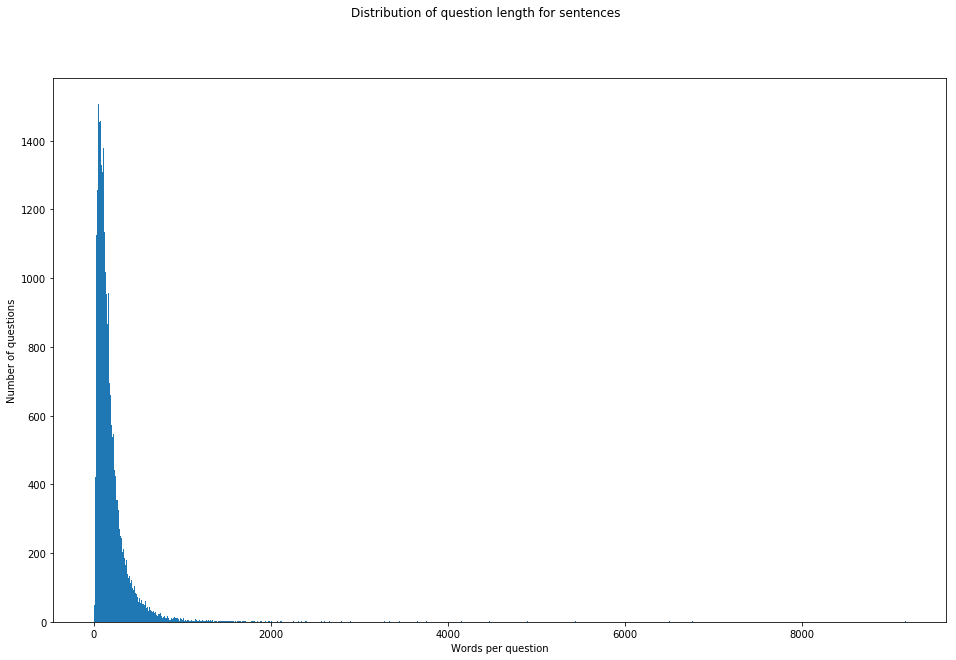

In [10]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Distribution of question length for sentences')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
q_len = plt.hist(df["question_len"], bins=1000, log=False)

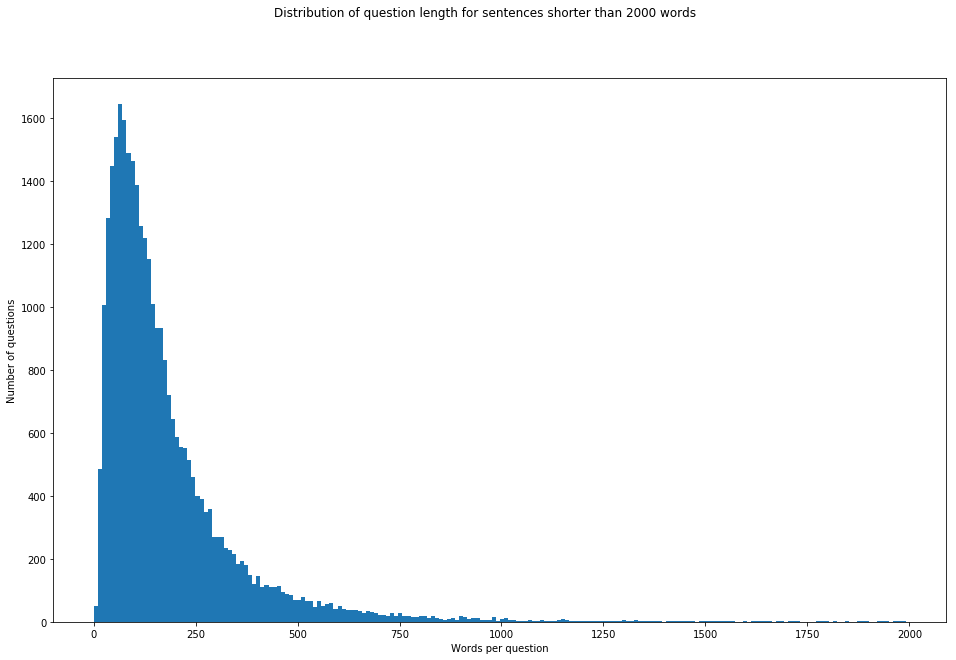

In [11]:
fig = plt.figure(figsize=(16,10))
fig.suptitle(
    'Distribution of question length for sentences shorter than 2000 words')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
plt.figsize=(16,10)
q_len_trunc = plt.hist(df[df["question_len"]<2000]["question_len"], bins=200, log=False)

Text(0, 0.5, 'Percentage of sentences')

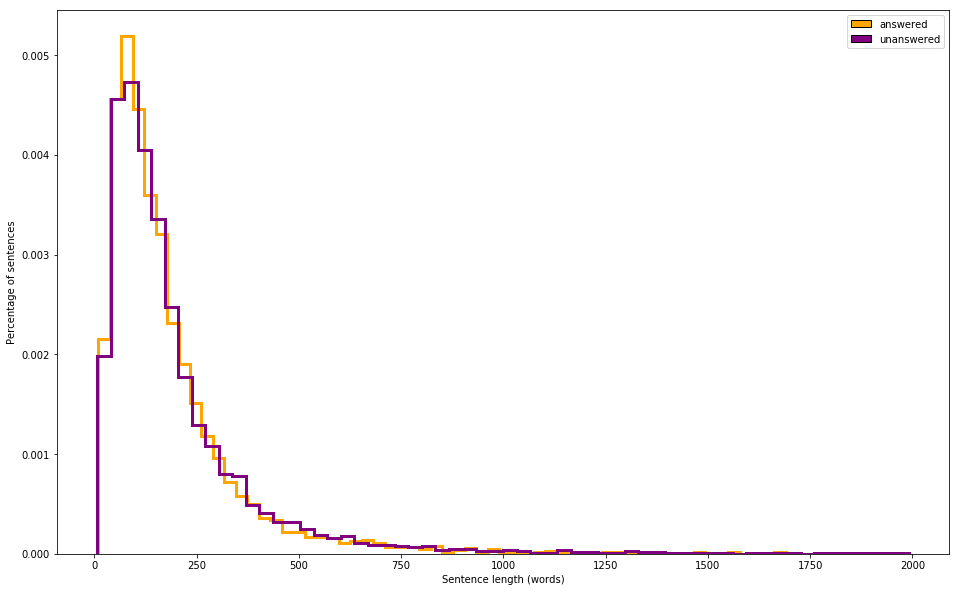

In [23]:
from matplotlib.patches import Rectangle

ax = df[df["is_question"] &
        ~(df["AcceptedAnswerId"].isna()) &
        (df["question_len"] < 2000)]["question_len"].hist(bins=60,
                                                          density=True,
                                                          histtype='step',
                                                          color='orange',
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   (df["AcceptedAnswerId"].isna()) &
   (df["question_len"] < 2000)]["question_len"].hist(bins=60,
                                                     density=True,
                                                     histtype='step',
                                                     color='purple',
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ['orange', 'purple']]
labels = ["answered", "unanswered"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (words)")
ax.set_ylabel("Percentage of sentences")

In [13]:
# no answers
df["AnswerCount"].value_counts()

-1     16785
 1      7105
 0      3584
 2      2577
 3       782
 4       263
 5        85
 6        32
 7        14
 8        13
 9         9
 10        5
 11        4
 14        3
 35        1
 12        1
 13        1
 17        1
 15        1
Name: AnswerCount, dtype: int64

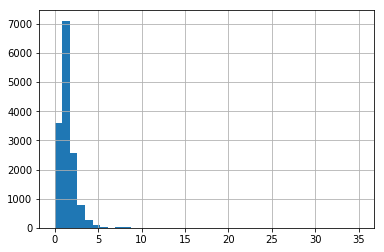

In [14]:
hist = df[df["AnswerCount"]!=-1]["AnswerCount"].hist(bins=40)

In [15]:
# How many questions have accepted answers
# What is the distribution of question scores
